<a href="https://colab.research.google.com/github/qraxiss/learning-data-science/blob/main/machine-learning/classification/cart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data & Libs

In [ ]:
!pip install skompiler

In [7]:
# Libs
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from google.colab import drive
from skompiler import skompile
from warnings import filterwarnings
filterwarnings('ignore')

# Data
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/learning-data-science-main/machine-learning/datas/diabetes.csv")
df = df.dropna()
df.index = np.arange(df.shape[0])

# X&y
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

# Test Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=31)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Model

In [9]:
cart_model = DecisionTreeClassifier().fit(X_train, y_train)

# Predict

In [10]:
print("Basic Accuracy Score",accuracy_score(y_test, cart_model.predict(X_test)))
print("CV Accuracy Score",cross_val_score(cart_model,
                                          X_test, 
                                          y_test, 
                                          cv=10).mean())

Basic Accuracy Score 0.683982683982684
CV Accuracy Score 0.718659420289855


# Python Code

In [ ]:
print(skompile(cart_model.predict).to("python/code"))

# Model Tuning

In [17]:
cart_grid = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50)) }

cart = DecisionTreeClassifier()
cart_cv = GridSearchCV(cart, cart_grid, cv = 3, n_jobs = -1, verbose = 2)
cart_cv_model = cart_cv.fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


In [18]:
print("En iyi skor:" + str(cart_cv_model.best_score_))
print("En iyi parametreler: " + str(cart_cv_model.best_params_))
params = pd.Series(cart_cv_model.best_params_)

En iyi skor:0.7728119180633147
En iyi parametreler: {'max_depth': 5, 'min_samples_split': 48}


## Tuned Model

In [20]:
cart = DecisionTreeClassifier(max_depth = params[0], min_samples_split = params[1])
cart_tuned = cart.fit(X_train, y_train) 

In [23]:
print("Basic Accuracy Score",accuracy_score(y_test, cart_tuned.predict(X_test)))
print("CV Accuracy Score",cross_val_score(cart_tuned,
                                          X_test, 
                                          y_test, 
                                          cv=10).mean())

Basic Accuracy Score 0.7142857142857143
CV Accuracy Score 0.7007246376811593


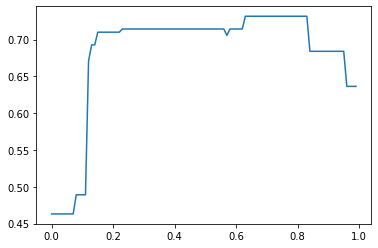

In [24]:
# Yüzdesel Oranlar
y_probs = pd.DataFrame(cart_tuned.predict_proba(X_test))
max = []
for j in np.arange(0,1,0.01):
  y_pred = np.array([1 if i > j else 0 for i in list(y_probs[1])])
  max.append([j ,accuracy_score(y_test, y_pred)])

max = np.array(max)

# Plot
import seaborn as sns
sns.lineplot(y=max[:,1], x=max[:,0])

# Plot

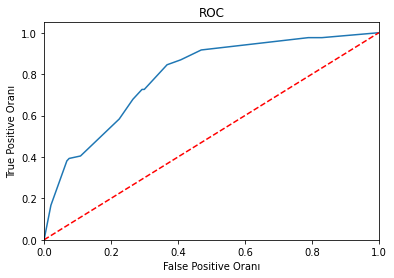

In [25]:
logit_roc_auc = roc_auc_score(y_test, cart_tuned.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, cart_tuned.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()